Code adapted from https://github.com/patrickcgray/open-geo-tutorial

# Preparing Dataset

In [1]:
from IPython.display import Audio, display
def alert():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [2]:
alert()

In [3]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.crs import CRS

In [4]:
import os # we need os to do some basic file operations
import re
regexp = re.compile(r'_B0[2348]')
sentinal_20m = "./Satellite_images/12_band_images/IMG_DATA_3\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_20m, f) for f in os.listdir(sentinal_20m) if regexp.search(f) ]
sentinal_band_paths.sort()
sentinal_band_paths

['./Satellite_images/12_band_images/IMG_DATA_3\\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\\T29TNF_20191211T112451_B02_10m.jp2',
 './Satellite_images/12_band_images/IMG_DATA_3\\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\\T29TNF_20191211T112451_B03_10m.jp2',
 './Satellite_images/12_band_images/IMG_DATA_3\\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\\T29TNF_20191211T112451_B04_10m.jp2',
 './Satellite_images/12_band_images/IMG_DATA_3\\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\\T29TNF_20191211T112451_B08_10m.jp2']

In [5]:
for i in sentinal_band_paths : 
        src = rasterio.open(i,driver='JP2OpenJPEG')
        meta = src.meta
        print( i + " ::: ")
        print(meta)


./Satellite_images/12_band_images/IMG_DATA_3\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\T29TNF_20191211T112451_B02_10m.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4600020.0)}
./Satellite_images/12_band_images/IMG_DATA_3\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\T29TNF_20191211T112451_B03_10m.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': None, 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4600020.0)}
./Satellite_images/12_band_images/IMG_DATA_3\S2A_MSIL2A_20191211T112451_N0213_R037_T29TNF_20191211T124129.SAFE/GRANULE/L2A_T29TNF_A023343_20191211T112448/IMG_DATA/R10m\T29TNF_20191211T112451_B04_10m.jp2

In [6]:

# create a products directory within the data dir which won't be uploaded to Github
img_dir = './data/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands_img_data_3.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0], driver='JP2OpenJPEG') as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))


In [7]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10980, 10980)
4


In [8]:
dataset=full_dataset
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
if (not proj) :
    proj = 'epsg:4936'
   # proj = CRS.from_dict(init='epsg:4936')
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ./data/sentinel_bands_img_data_3.tif

Number of bands in image: 4

Image size is: 10980 rows x 10980 columns

Raster description: (None, None, None, None)

Raster driver: JP2OpenJPEG

Image projection:
epsg:4936 

Image geo-transform:
| 10.00, 0.00, 499980.00|
| 0.00,-10.00, 4600020.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': None, 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4600020.0)}




Cutting arrays for faster process

In [9]:
cutx = 8000
cuty = 8500

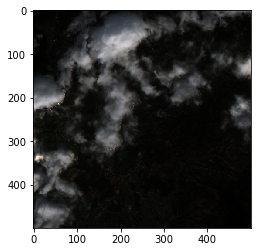

In [10]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image

rgb_norm = adjust_band(dataset.read([3,2,1])[:,cutx : cuty,cutx : cuty]) # normalize bands to range between 1.0 to 0.0

show(rgb_norm)

# Indices

In [11]:
with rasterio.open(img_fp) as src:
    green_band = src.read(2)[cutx : cuty, cutx : cuty] # band 3
    red_band = src.read(3)[cutx : cuty, cutx : cuty]   # band 4
    nir_band = src.read(4)[cutx : cuty, cutx : cuty]   # band 8
    img = src.read()[:, cutx : cuty, cutx : cuty]
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

In [12]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

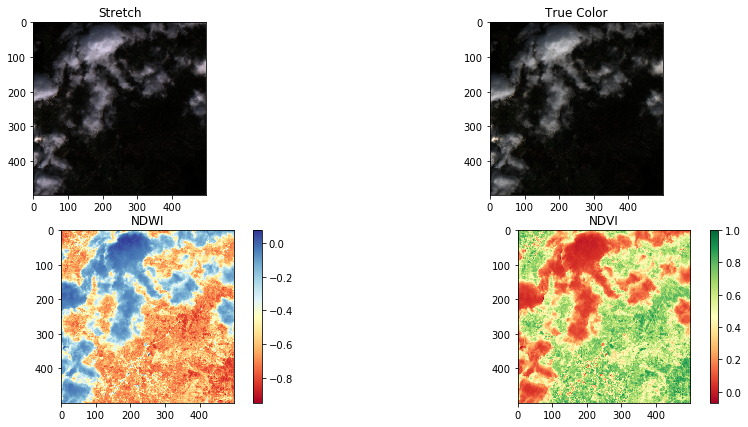

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

reshaped_img =reshape_as_image( img )
img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0,0].set_title("Stretch")
axs[0,0].imshow(img_stretched)

axs[0,1].set_title("True Color")
axs[0,1].imshow(reshape_as_image(rgb_norm))

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

# Testing an Unsupervised Classification Algorithm

In [14]:
from sklearn.cluster import KMeans

bands, rows, cols = img.shape
print(img.shape)
print(reshaped_img.shape)

(4, 500, 500)
(500, 500, 4)


In [15]:
k = 10 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(reshaped_img.reshape(-1, 4))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

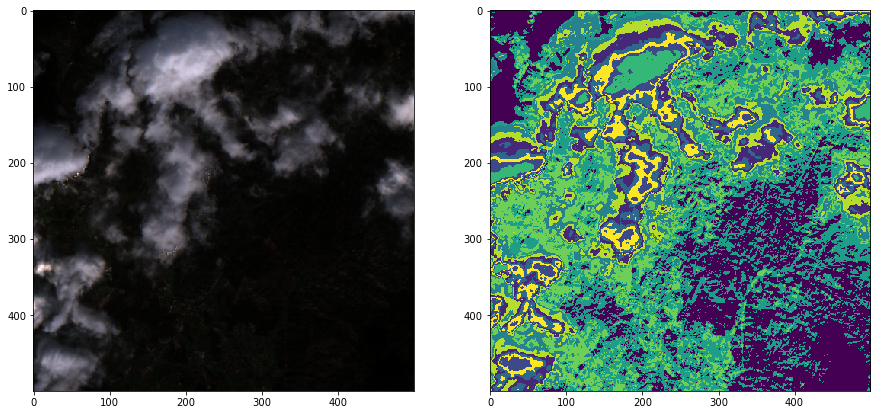

In [16]:
# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d)

In [17]:
alert()